In [5]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.optimize import minimize
from pynfft.nfft import NFFT
from ExoRIM.definitions import mas2rad, rad2mas
from ExoRIM.operators import NDFTM, Baselines
from scipy.ndimage import gaussian_filter
%matplotlib inline

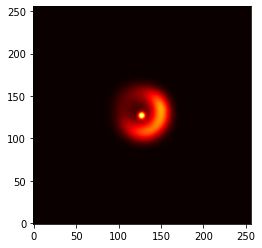

In [6]:
uv_data = fits.open("2004-data1.oifits")
# uv_data = fits.open("blackhole-01-05.oifits")
true_image = fits.open("2004true.fits")[0].data
# true_image = fits.open("blackhole-01-05.fits")[0].data
pixels = true_image.shape[0]
plt.imshow(true_image, cmap="hot", origin="lower")

In [7]:
uv_data[2].header

XTENSION= 'BINTABLE'           /Written by IDL:  Sat Apr 10 23:44:42 2004       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                  134 /Number of bytes per row                         
NAXIS2  =                    1 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                   17 /Number of columns                               
EXTNAME = 'OI_TARGET'          /name of this binary table extension             
TFORM1  = '1I      '           /Integer*2 (short integer)                       
TTYPE1  = 'TARGET_ID'          /Label for column 1                              
TFORM2  = '16A     '           /Character string                                
TTYPE2  = 'TARGET  '        

In [8]:
uv_data["OI_T3"].data["STA_INDEX"].min(axis=0)

array([0, 1, 2], dtype=int16)

Convention for bispectrum:
$$
    B(f_1, f_2) = V(f_1)V(f_2)\tilde{V}(f_1 + f_2) 
$$

In [9]:
try:
    amp_ref = uv_data["OI_VIS"].data["VISAMP"]
    amp_ref_error = uv_data["OI_VIS"].data["VISAMPERR"]
except KeyError:
    amp_ref = np.sqrt(np.abs(uv_data["OI_VIS2"].data["VIS2DATA"])) # 2004 data
    amp_ref_error = np.sqrt(np.sqrt(0.5)/amp_ref * uv_data["OI_VIS2"].data["VIS2ERR"]**2)
    
uv = np.column_stack([uv_data["OI_VIS2"].data["UCOORD"], uv_data[4].data["VCOORD"]])
uv1 = np.column_stack([uv_data["OI_T3"].data["U1COORD"], uv_data["OI_T3"].data["V1COORD"]])
uv2 = np.column_stack([uv_data["OI_T3"].data["U2COORD"], uv_data["OI_T3"].data["V2COORD"]])
cp_ref = uv_data["OI_T3"].data["T3PHI"]
cp_ref_error = uv_data["OI_T3"].data["T3PHIERR"]
rho = np.hypot(uv[:, 0], uv[:, 1])
wavel = uv_data["OI_WAVELENGTH"].data["EFF_WAVE"][0] # meter
baselines = len(uv_data["OI_VIS2"].data)
apertures = len(uv_data["OI_ARRAY"].data)
triangles = len(uv_data["OI_T3"].data)
parallax = uv_data["OI_TARGET"].data["PARALLAX"]/3600 # arcsec

print(baselines)
print(triangles)

195
130


Text(0.5, 1.0, 'uv coverage')

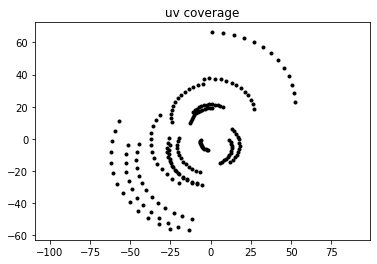

In [10]:
plt.plot(uv[:, 0], uv[:, 1], "k.")
plt.axis("equal")
plt.title("uv coverage")

In [11]:
def uniform_prior(image):
    return np.ones_like(image) * image.sum() / image.size

In [12]:
def chi2_amp(amp, amp_ref, amp_ref_error):
    return np.mean((amp - amp_ref)**2/amp_ref_error**2)

In [13]:
def chi2_cp(cp, cp_ref, cp_ref_error):
    return np.mean((cp - cp_ref)**2/cp_ref_error**2)

In [14]:
def tikhonov_reg(image, prior=None):
    if prior is None: # uniform prior
        prior = image.sum() / image.size
    return np.sum(image**2 / prior)

In [15]:
def safe_log(x):
    out = np.zeros_like(x)
    out[x <= 0] = -1000
    out[x > 0] = np.log(x[x > 0] + 1e-16)
    return out

def safe_exp(x):
    out = np.zeros_like(x)
    out[x > -20] = np.exp(x)
    return out

def maximum_entropy_reg(image, prior=None):
    if prior is None:
        prior = image.sum() / image.size
    return np.sum(image * safe_log(image / prior) - image + prior)
    

In [16]:
# def gaussian_prior(uv_data):
#     def log_likelihood(params, )

In [17]:
def baseline_projector(uv_data):
    baselines = len(uv_data["OI_VIS2"].data)
    apertures = len(uv_data["OI_ARRAY"].data)
    bp = np.zeros((baselines, apertures))
    indexes = uv_data["OI_VIS2"].data["STA_INDEX"]
    if indexes.min() >= 1:
        indexes -= indexes.min()
    for i in range(baselines):
        bp[i, indexes[i]] = 1
    return bp

def bispectra_projectors(uv_data):
    bp = baseline_projector(uv_data)
    triangles = len(uv_data["OI_T3"].data)
    time_uv = uv_data["OI_VIS2"].data["TIME"]
    time_bispectra = uv_data["OI_T3"].data["TIME"]
    sta_indexes = uv_data["OI_T3"].data["STA_INDEX"]
    if sta_indexes.min() >= 1:
        sta_indexes -= sta_indexes.min()
    
    bisp1 = np.zeros((triangles, bp.shape[0])) # projector to a triangle leg
    bisp2 = np.zeros_like(bisp1)
    bisp3 = np.zeros_like(bisp1)
    bisps = [bisp1, bisp2, bisp3]
    
    legs = [(0, 1), (1, 2), (0, 2)]
    
    # find a mapping between bispectra and each legs of each triangle
    for i, t in enumerate(time_bispectra):
        for j, leg in enumerate(legs):
            baseline = np.where((bp[:, sta_indexes[i, leg]] != 0).all(axis=1) & (time_uv == time_bispectra[i]))[0]
#             print(uv[baseline])
#             print(uv1[i])
#             print(uv2[i])
#             print(uv1[i] + uv2[i])
            assert (np.abs(uv[baseline][0] - [uv1[i], uv2[i], uv1[i] + uv2[i]][j]) < 1e-8).any()
            if len(baseline) == 1:
                bisps[j][i, baseline] = 1
            elif len(baseline) == 0: # this will happen when conjugate baselines are removed
                print(f"No match for V {i}, leg {leg} at time {t}")
            else:
                print(baseline)
    return bisps


In [640]:
class ForwardModel:

    def __init__(self, pixels, uv, plate_scale, wavel):
        self.pad = pixels//2
        self.plan = NFFT([2 * pixels, 2 * pixels], uv.shape[0], n=[2 * pixels, 2 * pixels])
        self.phase = np.exp(-1j * np.pi / wavel * mas2rad(plate_scale) * (uv[:, 0] + uv[:, 1]))
        self.bisps = bispectra_projectors(uv_data)
        self.plan.x = uv / wavel * mas2rad(plate_scale)
        self.plan.precompute()

    def visibility(self, image):
        # complex visibility
        image = image.reshape([pixels, pixels])
        _image = np.pad(image.copy(), [[pixels//2, pixels//2], [pixels//2, pixels//2]], mode="constant", constant_values=[(0, 0), (0, 0)])
        self.plan.f_hat = _image.ravel()
        self.plan.trafo()
        vis = self.plan.f.copy() * self.phase
        return vis

    def bispectra(self, V): # lexicographic convention
        V1 = self.bisps[0] @ V
        V2 = self.bisps[1] @ V
        V3 = self.bisps[2] @ V
        return V1 * V2 * V3.conj()

    def forward(self, image):
        V = self.visibility(image)
        amp = np.abs(V)
        cp = np.angle(self.bispectra(V))
        return amp, cp
    

<ErrorbarContainer object of 3 artists>

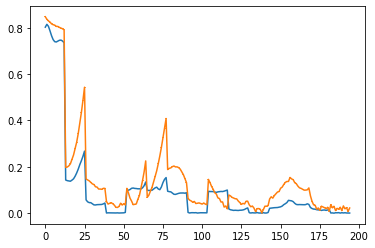

In [648]:
# Check that forward model works as intended


# f_hat = DFTM(uv)
rho = np.hypot(uv[:, 0], uv[:, 1])
plate_scale = rad2mas(wavel/4/np.max(rho))

forward = ForwardModel(pixels, uv, plate_scale, wavel)

amp, cp = forward.forward(true_image)
# compare = np.column_stack([np.rad2deg(cp), cp_ref])
# compare2 = np.column_stack([amp, vis_amp_ref])
# compare
# plt.plot(np.rad2deg(cp))
# plt.errorbar(np.arange(cp_ref.shape[0]), cp_ref, yerr=cp_ref_error)
plt.plot(6 * amp)
plt.errorbar(np.arange(amp_ref.shape[0]), amp_ref, yerr=amp_ref_error)

In [737]:
def likelihood(image, amp_ref, amp_ref_error, cp_ref, cp_ref_error, alpha, prior, forward):
    im = np.exp(image)
    im /= im.sum() # softmax link function
    amp, cp = forward.forward(im)
    chi1 = chi2_amp(amp, amp_ref, amp_ref_error)
    chi2 = chi2_cp(cp, cp_ref, cp_ref_error)
    reg1 = tikhonov_reg(im)
    reg2 = maximum_entropy_reg(im, prior)
#     print(chi1, chi2, alpha * reg2)
    return (chi1 + chi2 + alpha * (reg1 + reg1)) / (len(amp_ref) + len(cp_ref))

def grad_likelihood(image, amp_ref, amp_ref_error, cp_ref, cp_ref_error, alpha, prior, forward):
    im = np.exp(image)
    im /= im.sum()
    grad1 = grad_chi1_nfft(im, amp_ref, amp_ref_error, forward)
    grad2 = grad_chi2_nfft(im, cp_ref, cp_ref_error, forward)
    gradr1 = grad_reg1(im, prior)
    gradr2 = grad_reg2(im, prior)
    out = im * (grad1.ravel() + grad2.ravel() + alpha * (gradr1 + gradr2)) / (len(amp_ref) + len(cp_ref))
#     print((out**2).var())
    return out

def grad_chi1_nfft(image, amp_ref, amp_ref_error, forward):
    samples = np.abs(forward.visibility(image))**2
    sigma = amp_ref_error
    amp = amp_ref
    wdiff = -2./amp_ref.shape[0] * (samples - amp) * samples / sigma**2 / samples * forward.phase.conj()
    
    # inverse fourier transform
    forward.plan.f = wdiff
    out = np.real(forward.plan.adjoint())
    # remove the padding
    out = out.reshape([2*pixels, 2*pixels]).T
    out = out[pixels//2:-pixels//2, pixels//2:-pixels//2]
    return out


def grad_chi2_nfft(image, cp_ref, cp_ref_error, forward):
    V = forward.visibility(image)
    V1 = forward.bisps[0] @ V
    V2 = forward.bisps[1] @ V
    V3 = forward.bisps[2] @ V
    cp_samples = np.angle(V1 * V2 * V3.conj())
    
    # gradient for adjoint FFT
    wdiff = 2./len(cp_samples) * np.sin(cp_ref - cp_samples)/cp_ref_error**2
    p1 = wdiff / V1.conj()
    p2 = wdiff / V2
    p3 = wdiff / V3.conj()
    
    plan = NFFT([2*pixels, 2*pixels], V1.shape[0], n=[2*pixels, 2*pixels])
    x = forward.plan.x.copy()
    
    plan.x = np.einsum("ij, j... -> i...", forward.bisps[0], x)
    plan.precompute()
    plan.f = p1
    p1_hat = plan.adjoint() 
    out1 = np.imag(p1_hat)
    
    plan.x = np.einsum("ij, j... -> i...", forward.bisps[1], x)
    plan.precompute()
    plan.f = p2.conj()
    p2_hat = plan.adjoint()
    out2 = np.imag(p2_hat)
    
    plan.x = np.einsum("ij, j... -> i...", forward.bisps[2], x)
    plan.precompute()
    plan.f = p3
    p3_hat = plan.adjoint()
    out3 = np.imag(p3_hat)
    out = out1 + out2 + out3
    out = out.reshape([2*pixels, 2*pixels])
    out = out[pixels//2:-pixels//2, pixels//2:-pixels//2]
    return out

def grad_reg2(image, prior=None):
    if prior is None:
        prior = image.sum() / image.size
    out = safe_log(image / prior) +  prior - 1
    return out

def grad_reg1(image, prior=None):
    if prior is None:
        prior = image.sum() / image.size
    return 2 * image / prior


In [759]:
alpha = 0.5
x = np.arange(pixels) - pixels//2 + 0.5
xx, yy = np.meshgrid(x, x)
rho = np.hypot(xx, yy)
sigma = 40
prior = 1/2/np.pi/sigma * np.exp(-0.5 * rho**2 / sigma**2)

# prior = uniform_prior(true_image)
plate_scale = rad2mas(wavel/10/np.max(rho))
forward = ForwardModel(pixels, uv, plate_scale, wavel)

_amp_ref, _cp_ref = forward.forward(true_image)


x0 = safe_log(0.1 * prior + true_image +  np.random.uniform(0, 0.001, true_image.shape))
x0 = gaussian_filter(x0, sigma=3)


prior = safe_log(prior)
history = minimize(likelihood, x0, args=(_amp_ref, amp_ref_error, _cp_ref, cp_ref_error, alpha, prior.ravel(), forward), 
                   method="L-BFGS-B", jac=grad_likelihood, options={"maxiter": 200, "maxls": 100, "gtol": 1e-8, "ftol": 1e-8, "maxcor": 100})


In [760]:
print(likelihood(history.x, _amp_ref, amp_ref_error, _cp_ref, cp_ref_error, 0, prior.ravel(), forward))
history

69.21148209402006


      fun: 69.38896448618286
 hess_inv: <65536x65536 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.52578267e-08, -4.86092966e-08, -5.64704600e-08, ...,
       -6.36685815e-08, -6.29457638e-08, -6.24785497e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 28
      nit: 2
     njev: 28
   status: 0
  success: True
        x: array([-4.27549063, -4.20395502, -4.05395643, ..., -3.93425473,
       -3.94575724, -3.95329173])

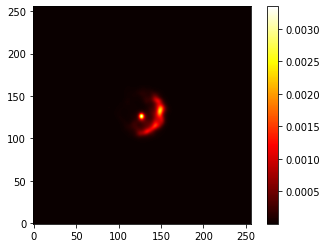

In [761]:
im = np.exp(history.x).reshape([pixels, pixels])
im /= im.sum()
# im = gaussian_filter(im, sigma=3)
# plt.imshow((im - true_image)**2, cmap="hot", origin="lower")
plt.imshow(im, cmap="hot", origin="lower")
plt.colorbar()

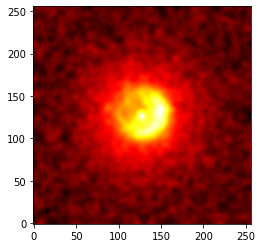

In [762]:
plt.imshow(np.exp(x0),cmap="hot", origin="lower")